# DeepSleep v2 


**Reasoning**:
I need to load the data from the provided CSV file into a pandas DataFrame and display the first few rows to verify.



In [1]:
import json
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.mixture import GaussianMixture

In [2]:
board="wemosd1"
r = 10
ds = 10
TX = 1

batteries = [0.8, 2, 4, 10] #Ah
deep_sleep_times = [0, 10, 30, 60, 600, 1800, 3600]

In [3]:
def load_data(filename, show=False):
    try:
        df = pd.read_csv(filename)
        if show:
            display(df.head())
    except FileNotFoundError:
        print(f"Error: '{fn}' not found.")
    except pd.errors.ParserError:
        print("Error: Unable to parse the CSV file. Check the file format.")
    except Exception as e:
        print(f"An unexpected error occurred: {e}")
    return df

In [4]:
experiment_name = f"--{board}_r{r}_ds{ds}-T{TX}"
filename = f"../data/dslp{experiment_name}.csv"
print(experiment_name)
print(filename)
df = load_data(filename, True)

--wemosd1_r10_ds10-T1
../data/dslp--wemosd1_r10_ds10-T1.csv


,index,read_at,millis,timestamp,voltage,current,power,bus_voltage
0,0,2025-03-04 21:57:04.178285,178179,2025-03-04 21:57:04,5.064,0.0756,0.38284,0.00756
1,1,2025-03-04 21:57:04.188464,178189,2025-03-04 21:57:04,5.064,0.0772,0.39094,0.00772
2,2,2025-03-04 21:57:04.198496,178199,2025-03-04 21:57:04,5.064,0.0772,0.39094,0.00772
3,3,2025-03-04 21:57:04.209697,178211,2025-03-04 21:57:04,5.064,0.0768,0.38892,0.00768
4,4,2025-03-04 21:57:04.220508,178221,2025-03-04 21:57:04,5.064,0.0764,0.38689,0.00764


In [5]:
def preprocess(df): 
    '''
    Check for missing values
    '''
    missing_values = df['current'].isnull().sum()
    missing_percentage = (missing_values / len(df['current'])) * 100
    print(f"Missing values in 'current' column: {missing_values} ({missing_percentage:.2f}%)")

    # Determine data type and convert if necessary
    print(f"Original data type of 'current' column: {df['current'].dtype}")
    if not pd.api.types.is_numeric_dtype(df['current']):
        try:
            df['current'] = pd.to_numeric(df['current'], errors='coerce')
            print("Converted 'current' column to numeric type.")
        except Exception as e:
            print(f"Error converting 'current' column: {e}")
    print(f"Data type of 'current' column after conversion: {df['current'].dtype}")

    # Calculate descriptive statistics
    descriptive_stats = df['current'].describe()
    print("\nDescriptive Statistics for 'current' column:")
    print(descriptive_stats)
    return df

df = preprocess(df)

Missing values in 'current' column: 0 (0.00%)
Original data type of 'current' column: float64
Data type of 'current' column after conversion: float64

Descriptive Statistics for 'current' column:
count    20982.000000
mean         0.048973
std          0.034268
min          0.000800
25%          0.000800
50%          0.068800
75%          0.072400
max          0.282800
Name: current, dtype: float64


## Data cleaning

**Reasoning**:
Clean the 'current' column by removing outliers using the IQR method and impute any remaining missing values with the median.


**NOTA: ALGO SE VE RARO EN ESTO, REVISAR EL MÉTODO, PUEDE SER QUE NO ELIMINE NADA **

In [6]:
def clean(df):
    quantile_low = 0.25
    quantile_high = 0.75
    iqr_factor = 1.5

    # Calculate Q1, Q3, and IQR
    Q1 = df['current'].quantile(quantile_low)
    Q3 = df['current'].quantile(quantile_high)
    IQR = Q3 - Q1

    # Define bounds for outlier removal
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    print(f"IQR lower_bound: {lower_bound}, upper_bound: {upper_bound})")

    # Remove outliers
    org_len = len(df['current'])
    df = df[~((df['current'] < lower_bound) | (df['current'] > upper_bound))]
    removed_len = len(df['current'])
    print(f"Length before IQR bounds: {org_len}, after: {removed_len}")

    # Display descriptive statistics after outlier removal
    print("\nDescriptive Statistics for 'current' column after outlier removal:")
    print(df['current'].describe())

    # Handle any remaining missing values
    if df['current'].isnull().any():
        median_current = df['current'].median()
        df['current'].fillna(median_current, inplace=True)
        print("\nDescriptive Statistics for 'current' column after imputation:")
        print(df['current'].describe())
    else:
        print("\nNo missing values found after outlier removal.")
    return df

df = clean(df)

IQR lower_bound: -0.10660000000000003, upper_bound: 0.17980000000000002)
Length before IQR bounds: 20982, after: 20938

Descriptive Statistics for 'current' column after outlier removal:
count    20938.000000
mean         0.048613
std          0.033366
min          0.000800
25%          0.000800
50%          0.068800
75%          0.072400
max          0.178400
Name: current, dtype: float64

No missing values found after outlier removal.


## Data analysis

**Reasoning**:
Calculate descriptive statistics, analyze trends using rolling mean, identify anomalies based on standard deviation thresholds, and visualize the results.



Descriptive Statistics for 'current' column:
count    20938.000000
mean         0.048613
std          0.033366
min          0.000800
25%          0.000800
50%          0.068800
75%          0.072400
max          0.178400
Name: current, dtype: float64


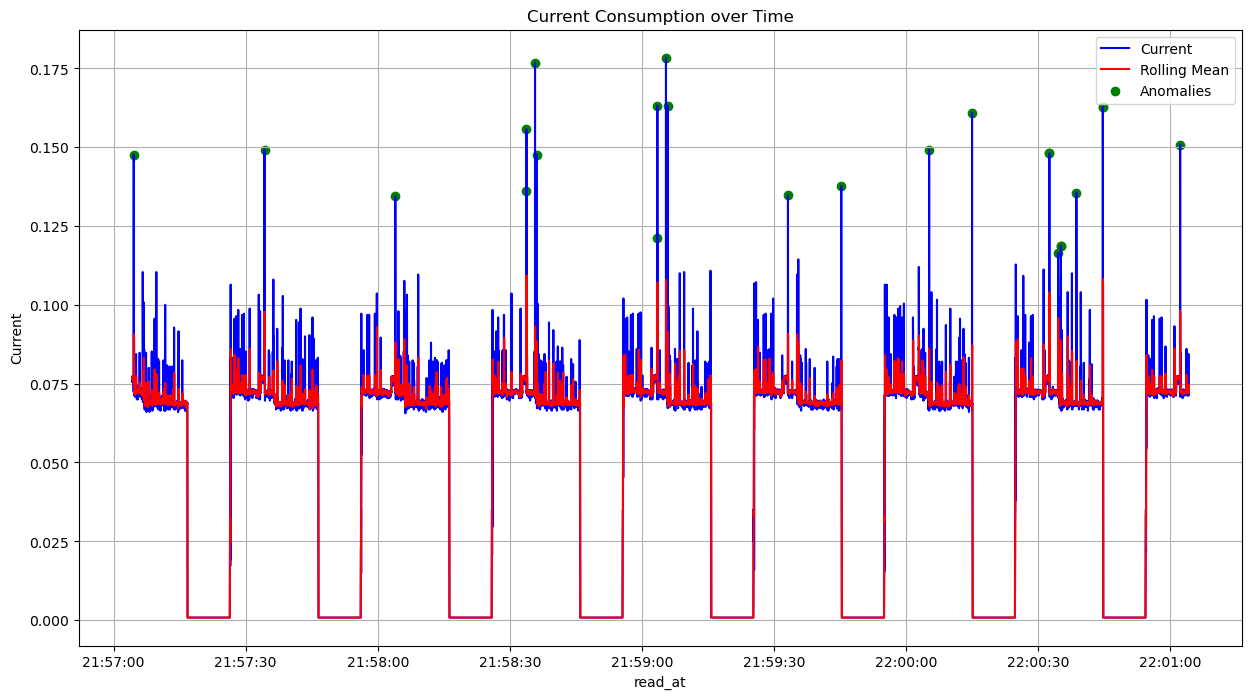


read_ats of Anomalies:
                         read_at  current
36    2025-03-04 21:57:04.574365   0.1476
2630  2025-03-04 21:57:34.271668   0.1492
5227  2025-03-04 21:58:03.973749   0.1344
7824  2025-03-04 21:58:33.720828   0.1360
7827  2025-03-04 21:58:33.754095   0.1556
7997  2025-03-04 21:58:35.700129   0.1768
8030  2025-03-04 21:58:36.066209   0.1476
10427 2025-03-04 21:59:03.437401   0.1212
10431 2025-03-04 21:59:03.482198   0.1632
10602 2025-03-04 21:59:05.436474   0.1784
10631 2025-03-04 21:59:05.798531   0.1632
13023 2025-03-04 21:59:33.139673   0.1348
14081 2025-03-04 21:59:45.240763   0.1376
15824 2025-03-04 22:00:05.192826   0.1492
16674 2025-03-04 22:00:14.938369   0.1608
18212 2025-03-04 22:00:32.486867   0.1480
18213 2025-03-04 22:00:32.496799   0.1480
18386 2025-03-04 22:00:34.475095   0.1164
18438 2025-03-04 22:00:35.088013   0.1188
18439 2025-03-04 22:00:35.101929   0.1188
18749 2025-03-04 22:00:38.630052   0.1356
19272 2025-03-04 22:00:44.619100   0.1628
19273 2025

In [7]:
# Convert 'read_at' to datetime objects
df['read_at'] = pd.to_datetime(df['read_at'])

# Calculate descriptive statistics
descriptive_stats = df['current'].describe()
print("Descriptive Statistics for 'current' column:")
print(descriptive_stats)

# Analyze trends using rolling mean
df['rolling_mean'] = df['current'].rolling(window=5, center=False).mean()

# Identify anomalies
std_dev = df['current'].std()
mean_current = df['current'].mean()
upper_threshold = mean_current + 2 * std_dev
lower_threshold = mean_current - 2 * std_dev

anomalies = df[(df['current'] > upper_threshold) | (df['current'] < lower_threshold)]

# Visualize trends and anomalies
plt.figure(figsize=(15, 8))
plt.plot(df['read_at'], df['current'], label='Current', color='blue')
plt.plot(df['read_at'], df['rolling_mean'], label='Rolling Mean', color='red')
plt.scatter(anomalies['read_at'], anomalies['current'], color='green', label='Anomalies')

plt.xlabel('read_at')
plt.ylabel('Current')
plt.title('Current Consumption over Time')
plt.legend()
plt.grid(True)
plt.show()

print("\nread_ats of Anomalies:")
print(anomalies[['read_at', 'current']])

<Axes: >

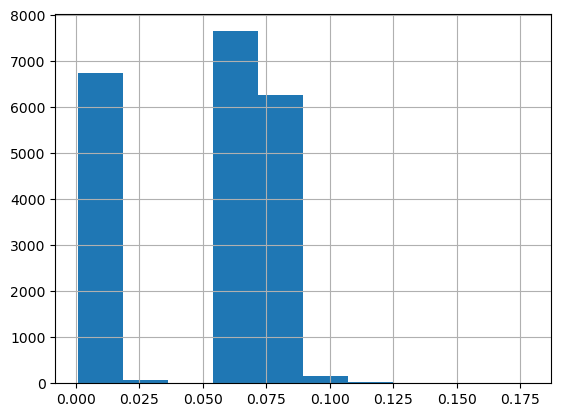

In [8]:
df.current.hist()

high_threshold: 0.036, low_threshold: 0.036
Samples excluded: 0


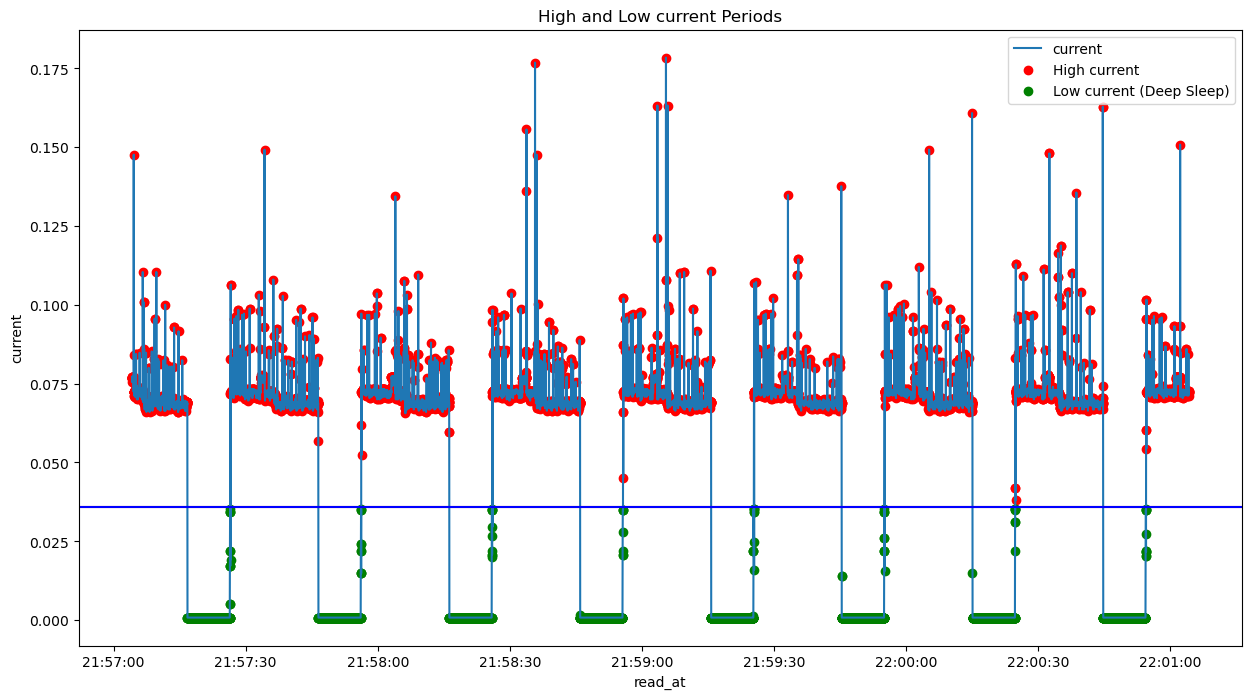

In [9]:
# Define thresholds for high and low current periods
#std_factor = 1.2 #efv: ajustado para los datos que tenemos
high_threshold = 0.036
low_threshold = 0.036

print(f"high_threshold: {high_threshold}, low_threshold: {low_threshold}")

# Extract high current periods
high_current_periods = df[df['current'] > high_threshold]

# Extract low current periods (deep sleep state)
low_current_periods = df[df['current'] < low_threshold]

excluded_count = ((df['current'] > low_threshold) & (df['current'] < high_threshold)).sum()

print(f"Samples excluded: {excluded_count}")

# Visualize the extracted periods
plt.figure(figsize=(15, 8))

plt.plot(df['read_at'], df['current'], label='current')
plt.scatter(high_current_periods['read_at'], high_current_periods['current'], color='red', label='High current')
plt.scatter(low_current_periods['read_at'], low_current_periods['current'], color='green', label='Low current (Deep Sleep)')
plt.axhline(high_threshold, color='red')
plt.axhline(low_threshold, color='blue')

plt.xlabel('read_at')
plt.ylabel('current')
plt.title('High and Low current Periods')
plt.legend()
plt.show()

In [10]:
## Define thresholds for high and low current periods
#std_factor = 1.2 #efv: ajustado para los datos que tenemos
#high_threshold = df['current'].mean() + std_factor * df['current'].std()  # Adjust as needed
#low_threshold = df['current'].mean() - std_factor * df['current'].std()  # Adjust as needed
#
#print(f"high_threshold: {high_threshold}, low_threshold: {low_threshold}")
#
## Extract high current periods
#high_current_periods = df[df['current'] > high_threshold]
#
## Extract low current periods (deep sleep state)
#low_current_periods = df[df['current'] < low_threshold]
#
#excluded_count = ((df['current'] > low_threshold) & (df['current'] < high_threshold)).sum()
#
#print(f"Samples excluded: {excluded_count}")
#
## Visualize the extracted periods
#plt.plot(df['read_at'], df['current'], label='current')
#plt.scatter(high_current_periods['read_at'], high_current_periods['current'], color='red', label='High current')
#plt.scatter(low_current_periods['read_at'], low_current_periods['current'], color='green', label='Low current (Deep Sleep)')
#plt.axhline(high_threshold, color='red')
#plt.axhline(low_threshold, color='blue')
#
#plt.xlabel('read_at')
#plt.ylabel('current')
#plt.title('High and Low current Periods')
#plt.legend()
#plt.show()

In [11]:
# Assuming 'high_current_periods' is the DataFrame containing high current periods
avg_high_current = high_current_periods['rolling_mean'].mean()

print(f"Average Current during High Current Periods: {avg_high_current}")

Average Current during High Current Periods: 0.0715124891943598


In [12]:
# Assuming 'low_current_periods' is the DataFrame containing deep sleep periods
avg_deep_sleep_current = low_current_periods['rolling_mean'].mean()

print(f"Average Current during Deep Sleep Periods: {avg_deep_sleep_current}")

Average Current during Deep Sleep Periods: 0.0012191291599472221


In [13]:
# prompt: Separate the cycles of high current usage and deep sleep

# Assuming 'df', 'high_current_periods', and 'low_current_periods' are already defined as in the original code.

def analyze_cycles(df, high_current_periods, low_current_periods):
    """Analyzes and separates high current usage cycles and deep sleep periods.
    """

    cycles = []
    # Iterate over the DataFrame and check for transitions between high and low current states.
    # This is a simplified representation, and the logic may need adjustment based on your specific requirements
    current_state = None
    start_time = None
    for index, row in df.iterrows():
      if row['read_at'] in high_current_periods['read_at'].values:
          if current_state != "high":  # Transition to high current state
              if current_state == "low":
                  cycles.append({"state":"low", "start_time":start_time, "end_time": row['read_at']})
              current_state = "high"
              start_time = row['read_at']
      elif row['read_at'] in low_current_periods['read_at'].values:
          if current_state != "low":  # Transition to low current state
              if current_state == "high":
                  cycles.append({"state":"high", "start_time":start_time, "end_time": row['read_at']})
              current_state = "low"
              start_time = row['read_at']

    # Handle the last cycle
    if start_time:
        cycles.append({"state":current_state, "start_time":start_time, "end_time": df['read_at'].iloc[-1]})

    return cycles

cycles = analyze_cycles(df, high_current_periods, low_current_periods)

# Example calculations for each cycle
from collections import defaultdict
durations = defaultdict(list)
for cycle in cycles[1:-1]:
    duration = cycle['end_time'] - cycle['start_time']
    durations[cycle['state']].append(duration.total_seconds())
    print(f"State: {cycle['state']},start: {cycle['start_time']}, end: {cycle['end_time']}, duration: {duration}")
    # Add other calculations as needed (e.g., average current within the cycle, energy consumption)

average_durations = {state: (sum(d) / len(d)) for state, d in durations.items()}
average_durations

State: low,start: 2025-03-04 21:57:16.758297, end: 2025-03-04 21:57:26.520594, duration: 0 days 00:00:09.762297
State: high,start: 2025-03-04 21:57:26.520594, end: 2025-03-04 21:57:26.563460, duration: 0 days 00:00:00.042866
State: low,start: 2025-03-04 21:57:26.563460, end: 2025-03-04 21:57:26.574752, duration: 0 days 00:00:00.011292
State: high,start: 2025-03-04 21:57:26.574752, end: 2025-03-04 21:57:46.493417, duration: 0 days 00:00:19.918665
State: low,start: 2025-03-04 21:57:46.493417, end: 2025-03-04 21:57:56.251942, duration: 0 days 00:00:09.758525
State: high,start: 2025-03-04 21:57:56.251942, end: 2025-03-04 21:58:16.230002, duration: 0 days 00:00:19.978060
State: low,start: 2025-03-04 21:58:16.230002, end: 2025-03-04 21:58:25.984302, duration: 0 days 00:00:09.754300
State: high,start: 2025-03-04 21:58:25.984302, end: 2025-03-04 21:58:26.028227, duration: 0 days 00:00:00.043925
State: low,start: 2025-03-04 21:58:26.028227, end: 2025-03-04 21:58:26.039218, duration: 0 days 00:0

{'low': 6.502923, 'high': 12.697705636363638}

In [14]:
# prompt: Compute the average current usage of each part of the cycles

# Assuming 'cycles' is the list of dictionaries as defined in the previous code.
for cycle in cycles[1:-1]:
    # Filter the DataFrame to include only data points within the current cycle
    cycle_data = df[(df['read_at'] >= cycle['start_time']) & (df['read_at'] <= cycle['end_time'])]

    # Calculate the average current for the current cycle
    avg_current = cycle_data['current'].mean()

    # Print the average current for the current cycle
    print(f"Average Current for Cycle ({cycle['state']}): {avg_current:.4f} A")


Average Current for Cycle (low): 0.0012 A
Average Current for Cycle (high): 0.0634 A
Average Current for Cycle (low): 0.0628 A
Average Current for Cycle (high): 0.0714 A
Average Current for Cycle (low): 0.0012 A
Average Current for Cycle (high): 0.0714 A
Average Current for Cycle (low): 0.0012 A
Average Current for Cycle (high): 0.0680 A
Average Current for Cycle (low): 0.0640 A
Average Current for Cycle (high): 0.0715 A
Average Current for Cycle (low): 0.0011 A
Average Current for Cycle (high): 0.0718 A
Average Current for Cycle (low): 0.0012 A
Average Current for Cycle (high): 0.0621 A
Average Current for Cycle (low): 0.0614 A
Average Current for Cycle (high): 0.0714 A
Average Current for Cycle (low): 0.0012 A
Average Current for Cycle (high): 0.0592 A
Average Current for Cycle (low): 0.0610 A
Average Current for Cycle (high): 0.0715 A
Average Current for Cycle (low): 0.0011 A
Average Current for Cycle (high): 0.0717 A
Average Current for Cycle (low): 0.0012 A


## Battery 

### deep sleep as measured by power_profiler

In [15]:
boards = json.loads(open("../data/boards.json").read())
boards

{'nodemcu': {'current': {'deep_sleep': 0.0092}},
 'saola': {'current': {'deep_sleep': 0.0009}},
 'wemosd1': {'current': {'deep_sleep': 6.5e-05}},
 'wemosc3mini': {'current': {'deep_sleep': 0.000418}}}

In [16]:
batteries = [0.8, 2, 4, 10] #Ah
avg_current = avg_high_current * average_durations['high'] + avg_deep_sleep_current * average_durations['low']
avg_current /= average_durations['high'] + average_durations['low']
print(f"Average current: {avg_current}")

for bat_usable_cap in batteries: #Amp hour
    runtime = bat_usable_cap / avg_current
    print(f"At {bat_usable_cap:.02f}Ah:\t{runtime:.01f} hours,\t{runtime/24:.02f} days")

Average current: 0.04770533598223279
At 0.80Ah:	16.8 hours,	0.70 days
At 2.00Ah:	41.9 hours,	1.75 days
At 4.00Ah:	83.8 hours,	3.49 days
At 10.00Ah:	209.6 hours,	8.73 days


### deep sleep current measured by multimeter

In [17]:
deep_sleep_measured_current = boards[board]["current"]["deep_sleep"]

avg_current = avg_high_current * average_durations['high'] + deep_sleep_measured_current * average_durations['low']
avg_current /= average_durations['high'] + average_durations['low']
print(f"Average current: {avg_current}")

for bat_usable_cap in batteries: #Amp hour
    runtime = bat_usable_cap / avg_current
    print(f"At {bat_usable_cap:.02f}Ah:\t{runtime:.01f} hours,\t{runtime/24:.02f} days")

Average current: 0.04731445226684352
At 0.80Ah:	16.9 hours,	0.70 days
At 2.00Ah:	42.3 hours,	1.76 days
At 4.00Ah:	84.5 hours,	3.52 days
At 10.00Ah:	211.4 hours,	8.81 days


### predicitions on estimated deep sleep

In [18]:
print(board)
run_time = average_durations['high']
for deep_sleep_time in deep_sleep_times:
    avg_current = avg_high_current * run_time + deep_sleep_measured_current * deep_sleep_time
    avg_current /= run_time + deep_sleep_time
    print(f"\nCycle run_time: {run_time}, deep_sleep_time: {deep_sleep_time}")
    print(f"  Average current: {avg_current}")

    for bat_usable_cap in batteries: #Amp hour
        bat_runtime = bat_usable_cap / avg_current
        print(f"  At {bat_usable_cap:.02f}Ah:\t{bat_runtime:.01f} hours,\t{bat_runtime/24:.02f} days")

wemosd1

Cycle run_time: 12.697705636363638, deep_sleep_time: 0
  Average current: 0.0715124891943598
  At 0.80Ah:	11.2 hours,	0.47 days
  At 2.00Ah:	28.0 hours,	1.17 days
  At 4.00Ah:	55.9 hours,	2.33 days
  At 10.00Ah:	139.8 hours,	5.83 days

Cycle run_time: 12.697705636363638, deep_sleep_time: 10
  Average current: 0.04003464278159512
  At 0.80Ah:	20.0 hours,	0.83 days
  At 2.00Ah:	50.0 hours,	2.08 days
  At 4.00Ah:	99.9 hours,	4.16 days
  At 10.00Ah:	249.8 hours,	10.41 days

Cycle run_time: 12.697705636363638, deep_sleep_time: 30
  Average current: 0.021312492639853145
  At 0.80Ah:	37.5 hours,	1.56 days
  At 2.00Ah:	93.8 hours,	3.91 days
  At 4.00Ah:	187.7 hours,	7.82 days
  At 10.00Ah:	469.2 hours,	19.55 days

Cycle run_time: 12.697705636363638, deep_sleep_time: 60
  Average current: 0.0125443372542621
  At 0.80Ah:	63.8 hours,	2.66 days
  At 2.00Ah:	159.4 hours,	6.64 days
  At 4.00Ah:	318.9 hours,	13.29 days
  At 10.00Ah:	797.2 hours,	33.22 days

Cycle run_time: 12.697705636363638

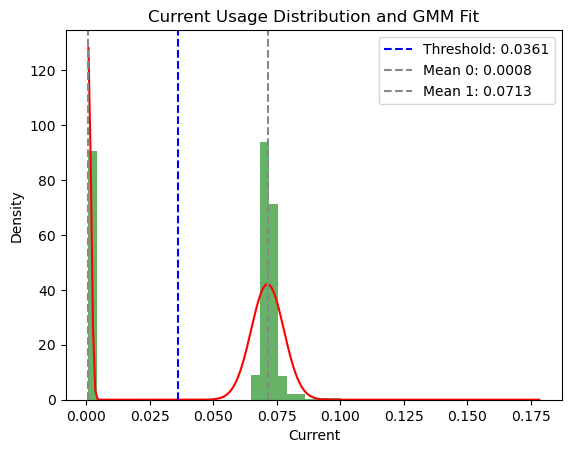

(0.036063467821796,
 array([0.00080148, 0.07132545]),
 array([0, 0, 0, ..., 0, 0, 0]))

In [19]:
def find_current_threshold(data, plot_results=False):
    """
    Finds a current threshold to separate high and low current usage modes using Gaussian Mixture Models.

    Args:
        data (pd.Series or np.array): The current usage data.
        plot_results (bool, optional): Whether to plot the histogram and GMM fit. Defaults to False.

    Returns:
        float: The current threshold separating the modes, or None if the fitting fails.
        array of means
        array of labels
    """

    if isinstance(data, pd.Series):
        data = data.values.reshape(-1, 1) #Reshape for sklearn
    elif isinstance(data, np.ndarray):
        data = data.reshape(-1, 1)
    else:
        raise TypeError("Input data must be a pandas Series or numpy array.")

    try:
        gmm = GaussianMixture(n_components=2)
        labels = gmm.fit_predict(data)
        means = gmm.means_.flatten()
        means.sort()  # Ensure means are sorted: low, high

        # Calculate the threshold as the midpoint between the means
        threshold = (means[0] + means[1]) / 2

        if plot_results:
            plt.hist(data, bins=50, density=True, alpha=0.6, color='g')
            x = np.linspace(data.min(), data.max(), 200).reshape(-1, 1)
            logprob = gmm.score_samples(x)
            pdf = np.exp(logprob)
            plt.plot(x, pdf, '-r')
            plt.axvline(threshold, color='b', linestyle='--', label=f'Threshold: {threshold:.4f}')
            plt.axvline(means[0], color="#888888", linestyle="--", label=f"Mean 0: {means[0]:.4f}")
            plt.axvline(means[1], color="#888888", linestyle="--", label=f"Mean 1: {means[1]:.4f}")
            plt.legend()
            plt.xlabel("Current")
            plt.ylabel("Density")
            plt.title("Current Usage Distribution and GMM Fit")
            plt.show()

        return threshold, means, labels

    except Exception as e:
        print(f"Error during GMM fitting: {e}")
        return None

#Example Usage
# Create a sample dataset (replace with your actual data)

find_current_threshold(df.current, plot_results=True)


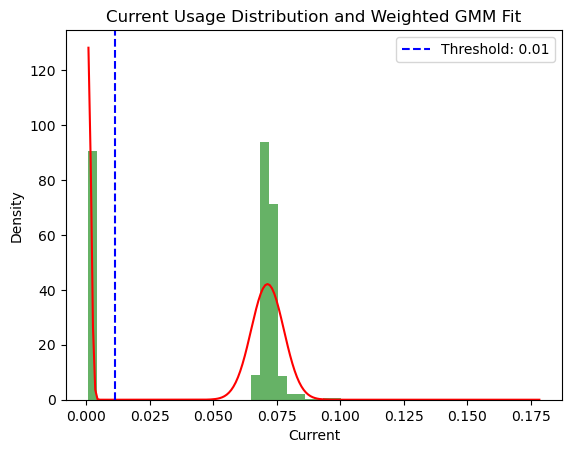

0.011380078460138101

In [20]:
def find_current_threshold_weighted(data, weight_low_std=0.6, plot_results=False):
    """
    Finds a current threshold to separate high and low current usage modes using Gaussian Mixture Models,
    and weights the threshold towards the distribution with lower standard deviation.

    Args:
        data (pd.Series or np.array): The current usage data.
        weight_low_std (float, optional): Weight for the mean of the distribution with lower std (0 to 1). Defaults to 0.6.
        plot_results (bool, optional): Whether to plot the histogram and GMM fit. Defaults to False.

    Returns:
        float: The current threshold separating the modes, or None if the fitting fails.
    """

    if isinstance(data, pd.Series):
        data = data.values.reshape(-1, 1)
    elif isinstance(data, np.ndarray):
        data = data.reshape(-1, 1)
    else:
        raise TypeError("Input data must be a pandas Series or numpy array.")

    try:
        gmm = GaussianMixture(n_components=2)
        gmm.fit(data)
        means = gmm.means_.flatten()
        stds = np.sqrt(gmm.covariances_).flatten()
        means.sort()
        stds.sort() #sort stds to match means sorting
        #efv: TREMENDO BUG QUE METE GEMINI AQUI: esto no garantiza que esten en el mismo orden:
        #ej: means = [2, 1] stds = [.1, .2] al hacer el sort ya no se corresponden stds con means
        #.  => means = [1, 2] stds = [.1, .2]
        #Pero no importa porque no usa stds para nada!! ver abajo!

        # Weighted threshold calculation
        threshold = means[0] * weight_low_std + means[1] * (1 - weight_low_std)
        
        #Al pedir que lo arreglara hizo esto, pero no lo voy a usar, no vale la pena:
#        # Determine which mean has the lower std
#        if stds[0] < stds[1]:
#            mean_low_std = means[0]
#            mean_high_std = means[1]
#        else:
#            mean_low_std = means[1]
#            mean_high_std = means[0]
#
#        # Weighted threshold calculation using stds
#        threshold = mean_low_std * weight_low_std + mean_high_std * (1 - weight_low_std)


        if plot_results:
            plt.hist(data, bins=50, density=True, alpha=0.6, color='g')
            x = np.linspace(data.min(), data.max(), 200).reshape(-1, 1)
            logprob = gmm.score_samples(x)
            pdf = np.exp(logprob)
            plt.plot(x, pdf, '-r')
            plt.axvline(threshold, color='b', linestyle='--', label=f'Threshold: {threshold:.2f}')
            plt.legend()
            plt.xlabel("Current")
            plt.ylabel("Density")
            plt.title("Current Usage Distribution and Weighted GMM Fit")
            plt.show()

        return threshold

    except Exception as e:
        print(f"Error during GMM fitting: {e}")
        return None
    
find_current_threshold_weighted(df.current, weight_low_std=0.85, plot_results=True)
